<a href="https://colab.research.google.com/github/Arthur-ca/MIE1517/blob/Jing-Guo/ExtractFeatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import os
from sklearn.model_selection import train_test_split
import random
import torchvision
from torchvision import datasets, models
from collections import defaultdict
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as F1
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision.datasets import ImageFolder
import tensorflow as tf
import gc
from collections import Counter
import imgaug.augmenters as iaa
import cv2
import dlib
from collections import defaultdict
from matplotlib import pyplot as plt

In [ ]:
#First link it to google drive and check the subfolder of the data
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
classeses = []
for i in os.listdir('/content/gdrive/My Drive/ColabNotebooks/archive'):
    if i!=5:
        classeses.append(i)
classeses

['neutrality',
 'sadness',
 'fear',
 'surprise',
 'contempt',
 'happiness',
 'anger',
 'disgust']

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
drive_content = os.listdir('/content/gdrive/My Drive/ColabNotebooks/')
print(drive_content)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['Untitled0.ipynb', 'Untitled (3)', 'coding_exercises_1_and_2.ipynb', 'Untitled (2)', 'ANN Classification with Lists.ipynb', 'ANN_2layer_example.ipynb', 'A1 (1).ipynb', 'Untitled (1)', 'A1.ipynb', 'A2_Hand_Gesture_Dataset.zip', 'Untitled', 'Lab_3b_Gesture_Dataset', 'ECE1513A1.ipynb', 'SignL', 'new', 'Feature', 'A2.ipynb', 'IMDB Dataset.csv', 'archive', 'shape_predictor_68_face_landmarks.dat']


In [ ]:
import cv2
import dlib
import numpy as np
import os
from collections import Counter

# Initialize Dlib's face detector (HOG-based) and facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/shape_predictor_68_face_landmarks.dat')

# Function to extract and combine eyes, eyebrows, and mouth into a single image
def extract_and_combine_regions(gray, landmarks):
    # Create masks for eyes including eyebrows and mouth
    mask_eyes_eyebrows = np.zeros_like(gray)
    mask_mouth = np.zeros_like(gray)

    # Points for eyes and eyebrows
    eyes_eyebrows_points = np.concatenate([
        np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(17, 27)]),  # Eyebrows
        np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 48)])   # Eyes
    ])

    # Points for mouth
    mouth_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(48, 68)])  # Mouth

    # Fill the masks with the polygons defined by points
    cv2.fillPoly(mask_eyes_eyebrows, [eyes_eyebrows_points], 255)
    cv2.fillPoly(mask_mouth, [mouth_points], 255)

    # Use the masks to extract the regions from the image
    eyes_eyebrows_region = cv2.bitwise_and(gray, mask_eyes_eyebrows)
    mouth_region = cv2.bitwise_and(gray, mask_mouth)

    # Combine the regions on a black background
    combined_image = np.zeros_like(gray)
    combined_image[mask_eyes_eyebrows == 255] = eyes_eyebrows_region[mask_eyes_eyebrows == 255]
    combined_image[mask_mouth == 255] = mouth_region[mask_mouth == 255]

    return combined_image

# Your existing code to load images
features_or = []
labels_or = []
train_data_or = []
def create_images():
    for i, photo in enumerate(classeses):
        path = os.path.join('/content/gdrive/My Drive/ColabNotebooks/archive', photo)
        label = i  # Use the index of the class as the label

        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)

            if img is None:
                continue

            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            faces = detector(gray, 1)

            if len(faces) > 0:
                face = faces[0]
                landmarks = predictor(gray, face)
                combined_region = extract_and_combine_regions(gray, landmarks)

                # Append the combined image and its label to the list
                features_or.append(combined_region)  # Append the combined region
                labels_or.append(label)

                train_data_or.append([combined_region, label])
            else:
                print(f"Face not detected in image: {img_path}")

create_images()

# Print the label counts
label_counts_or = Counter(labels_or)
for label, count in label_counts_or.items():
    print(f"Label {label}: {count} images")

In [ ]:
label_counts = Counter(eyes_labels)

# Print the count for each label
for label, count in label_counts.items():
    print(f"Label {label}: {count} images")

Label 0: 419 images
Label 1: 448 images
Label 2: 372 images
Label 3: 610 images
Label 4: 142 images
Label 5: 896 images
Label 6: 585 images
Label 7: 292 images


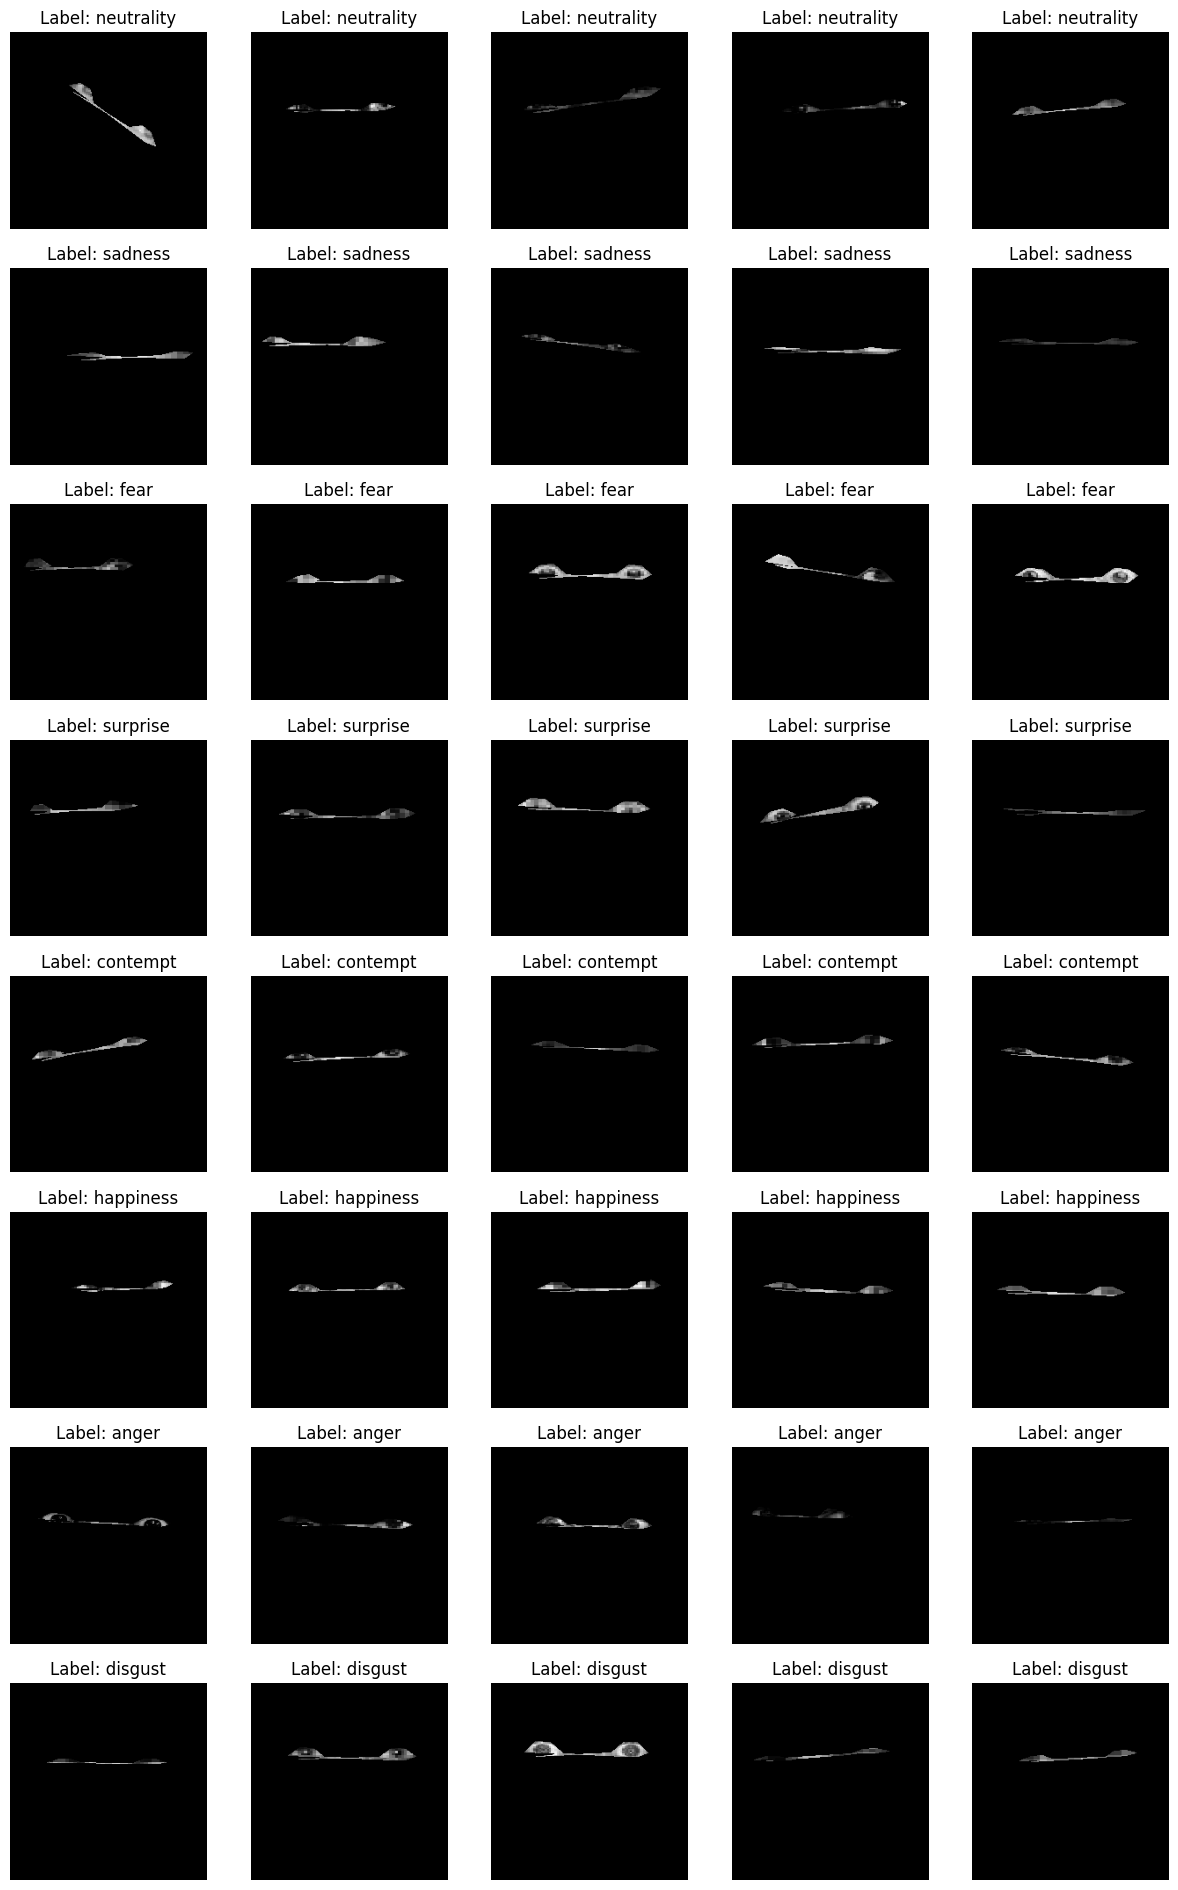

Label 0: 5 images
Label 1: 5 images
Label 2: 5 images
Label 3: 5 images
Label 4: 5 images
Label 5: 5 images
Label 6: 5 images
Label 7: 5 images


In [ ]:
def plot_first_n_images(images, labels, number):
    num_labels = len(set(labels))  # Get the number of unique labels
    num_rows = (number - 1) // 5 + 1  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows * num_labels, 5, figsize=(15, 3 * num_rows * num_labels))

    label_counts = defaultdict(int)  # Keep track of the count for each label

    for i, unique_label in enumerate(set(labels)):
        images_for_label = [(img, img_label) for img, img_label in zip(images, labels) if img_label == unique_label]
        for j in range(5):
            index = i * 5 + j
            if index < number*num_labels and j < len(images_for_label):
                img, img_label = images_for_label[j]
                axes[i, j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                axes[i, j].set_title(f"Label: {classeses[img_label]}")
                axes[i, j].axis('off')

                # Increment the count for the current label
                label_counts[img_label] += 1

    plt.show()

    # Print the count for each label
    for label, count in label_counts.items():
        print(f"Label {label}: {count} images")

# Example usage
plot_first_n_images(eyes_images, eyes_labels, 5)

Load data for each part of face(eyes, eyebrow, and mouth)

In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import random_split
# Preprocess and transform the images
transform = transforms.Compose([
    transforms.ToTensor(),
    # Add any additional transforms you might need
])

# Convert the processed images and labels into tensors and apply transforms
def prepare_dataset(images, labels, transform):
    tensor_images = [transform(image) for image in images]
    tensor_labels = torch.tensor(labels, dtype=torch.long)
    return TensorDataset(torch.stack(tensor_images), tensor_labels)

# Prepare datasets for eyes, eyebrows, and mouth
eye_dataset = prepare_dataset(eyes_images, eyes_labels, transform)
eyebrow_dataset = prepare_dataset(eyebrows_images, eyebrows_labels, transform)
mouth_dataset = prepare_dataset(mouth_images, mouth_labels, transform)

# split your datasets into training, validation, and test sets with a 60-20-20 percent ratio,
def split_dataset(dataset, train_percent=0.60, val_percent=0.20):
    total_size = len(dataset)
    train_size = int(total_size * train_percent)
    val_size = int(total_size * val_percent)
    test_size = total_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    return train_dataset, val_dataset, test_dataset

# Prepare datasets for eyes, eyebrows, and mouth
eye_dataset = prepare_dataset(eyes_images, eyes_labels, transform)
eyebrow_dataset = prepare_dataset(eyebrows_images, eyebrows_labels, transform)
mouth_dataset = prepare_dataset(mouth_images, mouth_labels, transform)

# Split each dataset into training, validation, and test sets
eye_train_dataset, eye_val_dataset, eye_test_dataset = split_dataset(eye_dataset)
eyebrow_train_dataset, eyebrow_val_dataset, eyebrow_test_dataset = split_dataset(eyebrow_dataset)
mouth_train_dataset, mouth_val_dataset, mouth_test_dataset = split_dataset(mouth_dataset)

# Create DataLoaders for training and validation for each region
eye_train_loader = DataLoader(eye_train_dataset, batch_size=64, shuffle=True)
eye_val_loader = DataLoader(eye_val_dataset, batch_size=64, shuffle=False)

eyebrow_train_loader = DataLoader(eyebrow_train_dataset, batch_size=64, shuffle=True)
eyebrow_val_loader = DataLoader(eyebrow_val_dataset, batch_size=64, shuffle=False)

mouth_train_loader = DataLoader(mouth_train_dataset, batch_size=64, shuffle=True)
mouth_val_loader = DataLoader(mouth_val_dataset, batch_size=64, shuffle=False)

Model

In [9]:
# Model for eyes, eyebrows, and mouth regions
class RegionCNN(nn.Module):
    def __init__(self, num_classes):
        super(RegionCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        # Assuming that the input image size is 224x224
        self.classifier = nn.Sequential(
            nn.Linear(128 * 28 * 28, 1024),  # Adjust size as needed based on  dimensions
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x, return_feature_vector=False):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten for fully connected layer
        x = F.relu(self.classifier[0](x))  # First fully connected layer + ReLU
        feature_vector = F.relu(self.classifier[1](x))  # Second fully connected layer + ReLU

        if return_feature_vector:
            return feature_vector  # Return the feature vector before the final classification layer

        x = self.classifier[2](feature_vector)  # Final classification layer
        return x

# Final model for expression classification
class FinalExpressionCNN(nn.Module):
    def __init__(self, num_classes, combined_feature_size):
        super(FinalExpressionCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(combined_feature_size, 64, kernel_size=3, padding=1),  # combined_feature_size include the depth of concatenated feature maps
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        # Assuming that the input image size is 224x224
        self.classifier = nn.Sequential(
            nn.Linear(128 * 56 * 56, 1024),  # Adjust size as needed based on input dimensions
            nn.ReLU(),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x, eyebrow_features, eye_features, mouth_features):
        # Concatenate the features from the region-specific CNNs with the full face input
        combined_features = torch.cat((x, eyebrow_features, eye_features, mouth_features), dim=1)
        combined_features = self.features(combined_features)
        combined_features = combined_features.view(combined_features.size(0), -1)
        x = self.classifier(combined_features)
        return x

# Example usage
num_classes = 8
combined_feature_size = 1 + 3 * 128  # 1 for grayscale image, 128 for each of the 3 features
eyebrow_model = RegionCNN(num_classes)
eye_model = RegionCNN(num_classes)
mouth_model = RegionCNN(num_classes)
final_model = FinalExpressionCNN(num_classes, combined_feature_size)

NameError: ignored

Train Region-Specific CNNs (RegionCNN):
Train the RegionCNN models separately for each facial region (eyes, eyebrows, mouth) using the corresponding part of the face images.


In [1]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
    return path

def evaluate(model, loader):
    """ Evaluate the network """
    correct = 0
    total = 0

    for inputs, labels in loader:
      if use_cuda and torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()

      outputs = model(inputs)
      predicted = outputs.max(1, keepdim=True)[1]
      total += inputs.shape[0]
      correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return correct / total

In [2]:
def trainmodel(model, train_dataset, val_dataset, batch=64, learningRate=0.01, num_epochs=300):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learningRate)

    model_checkpoint_path = 'D:/MIE1517/output'

    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

    train_accuracy = np.zeros(num_epochs)
    train_losses = np.zeros(num_epochs)
    validation_accuracy = np.zeros(num_epochs)
    validation_losses = np.zeros(num_epochs)

    use_cuda = torch.cuda.is_available()
    if use_cuda:
        model = model.cuda()

    print("Training Begin...\n")
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            if use_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses[epoch] = running_loss / len(train_loader)
        train_accuracy[epoch] = evaluate(model, train_loader)

        model.eval()
        valid_loss = 0.0
        for inputs, labels in val_loader:
            if use_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

        validation_losses[epoch] = valid_loss / len(val_loader)
        validation_accuracy[epoch] = evaluate(model, val_loader)

        print(f"Epoch {epoch+1}: Train Acc: {train_accuracy[epoch]:.2f}, Train Loss: {train_losses[epoch]:.4f} | "
              f"Val Acc: {validation_accuracy[epoch]:.2f}, Val Loss: {validation_losses[epoch]:.4f}")

        model_path = get_model_name(model.name, batch, learningRate, epoch)
        model_path = os.path.join(model_checkpoint_path, model_path)
        torch.save(model.state_dict(), f"{model_path}.pt")

    print("Finished Training")
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total time elapsed: {elapsed_time:.2f} seconds")

    # Plotting
    epochs = np.arange(1, num_epochs + 1)
    plt.figure(figsize=(14, 7))

    plt.subplot(2, 1, 1)
    plt.title("Training and Validation Loss")
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, validation_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.title("Training and Validation Accuracy")
    plt.plot(epochs, train_accuracy, label="Train Accuracy")
    plt.plot(epochs, validation_accuracy, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return train_losses, train_accuracy, validation_losses, validation_accuracy

In [ ]:
eye_training = trainmodel(eye_model, eye_train_dataset, eye_val_dataset, batch=64, learningRate=0.01, num_epochs=300)
eyebrow_training = trainmodel(eyebrow_model, eyebrow_train_dataset, eyebrow_val_dataset, batch=64, learningRate=0.01, num_epochs=300)
mouth_training = trainmodel(mouth_model, mouth_train_dataset, mouth_val_dataset, batch=64, learningRate=0.01, num_epochs=300)

Extract Features Using Trained RegionCNNs

Once each RegionCNN is trained, use them to extract features from their respective regions on the training dataset. This means running each region image through its corresponding RegionCNN and saving the output features (just before the final classification layer).
These features are what the FinalExpressionCNN will use, so you need to save them in a format that can be used for further training.

In [3]:
def extract_features(model, loader):
    model.eval()  # Set the model to evaluation mode
    features = []
    with torch.no_grad():  # Disable gradient computation
        for inputs, _ in loader:
            if torch.cuda.is_available():
                inputs = inputs.cuda()
            feature_vector = model(inputs, return_feature_vector=True)
            features.append(feature_vector.cpu())  # If using GPU, move to CPU
    return torch.cat(features)  # Concatenate all features into a single tensor

In [ ]:
#training feature
eye_features_train = extract_features(eye_model, eye_train_loader)
eyebrow_features_train = extract_features(eyebrow_model, eyebrow_train_loader)
mouth_features_train = extract_features(mouth_model, mouth_train_loader)
#validation feature
eye_features_val = extract_features(eye_model, eye_val_loader)
eyebrow_features_val = extract_features(eyebrow_model, eyebrow_val_loader)
mouth_features_val = extract_features(mouth_model, mouth_val_loader)

Combine Extracted Features:
Combine the extracted features from each RegionCNN into a single, larger feature vector for each image.

In [ ]:
def combine_features(eye_features, eyebrow_features, mouth_features):
    combined = torch.cat((eye_features, eyebrow_features, mouth_features), dim=1)
    return combined


In [ ]:
combine_features_train = combine_features(eye_features_val, eyebrow_features_val, mouth_features_val)
combine_features_val = combine_features(eye_features_val, eyebrow_features_val, mouth_features_val)

Train FinalExpressionCNN:
Use these combined feature vectors as input to FinalExpressionCNN.
Train FinalExpressionCNN to classify expressions based on the combined feature

In [ ]:
combined_labels = torch.tensor(labels_or) #根据guojin的code来的 可能实际测试的时候要改一下

# Create a new TensorDataset for combined features and labels
combined_train_dataset = torch.utils.data.TensorDataset(combine_features_train, combined_labels)
combined_train_loader = DataLoader(combined_train_dataset, batch_size=64, shuffle=True)

# validation dataset

combined_val_dataset = torch.utils.data.TensorDataset(combine_features_val, combined_labels) # create combined dataset for validation
combined_val_loader = DataLoader(combined_val_dataset, batch_size=64, shuffle=False)

# Train the final model using the combined datasets
final_training = trainmodel(final_model, combined_train_loader, combined_val_loader, batch=64, learningRate=0.01, num_epochs=300)

Full System Inference:
In the operational phase, when run inference to predict expressions, I will pass the new image through each RegionCNN to extract features and then through the FinalExpressionCNN to get the final expression classification.

In [ ]:
# 可以先不管这个part， 这个是给新的dataset用的

def full_system_inference(models, final_model, image):
    # Assume `models` is a list of trained region-specific models in the order: [eye_model, eyebrow_model, mouth_model]
    features = []
    for model in models:
        region = extract_region_from_image(image, model.region)  # This function needs to be implemented
        feature = extract_features(model, region)
        features.append(feature)

    combined_feature = combine_features(*features)
    final_output = final_model(combined_feature.unsqueeze(0))  # Add batch dimension
    return final_output